In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.calibration import calibration_curve
import joblib
import os
import lightgbm as lgb

In [2]:
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

In [3]:
fold = 1

In [6]:
x_val = pd.read_pickle('Output/x_val_fold_{}.pkl'.format(fold))
y_val = pd.read_pickle('Output/y_val_fold_{}.pkl'.format(fold))

In [7]:
path = 'Models/'
for fname in os.listdir(path):
    if fname.startswith("fold_{}".format(fold)):
        print(fname)
        model = joblib.load('Models/' + fname)

fold_1_iter_16183_score_0.79449.pkl


In [8]:
pred_x_val = model.predict(x_val)
pred_x_val = pd.DataFrame(pred_x_val, index = x_val.index, columns=['pred'])
pred_x_val.shape

(91783, 1)

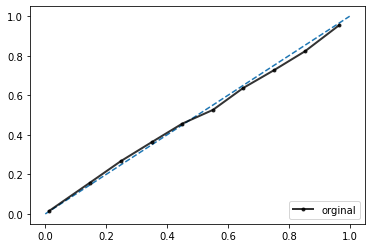

In [9]:
gb_y_test, gb_x_test = calibration_curve(y_val, pred_x_val, n_bins=10)


plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(gb_x_test, gb_y_test, marker='.', lw=2, color='black', label='orginal', alpha=.8)
plt.legend(loc='lower right')
plt.show()